# 1. Importação das bibliotecas

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import pickle
import requests
import io
from io import StringIO
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 2. Leitura do arquivo extraído no site do ipea

In [32]:
url = 'https://drive.google.com/uc?id=1ilAXCcKolm_2WAVdiC_1ycQTq5zHMwhj'
response = requests.get(url)
response.raise_for_status()

In [33]:
df = pd.read_csv(StringIO(response.text), sep=';', decimal=',')
df = df.drop(df.columns[2], axis=1)
df.columns = ['DAT_MEDICAO', 'VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT']

# 3. Informações iniciais da base

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13768 entries, 0 to 13767
Data columns (total 2 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   DAT_MEDICAO                            13768 non-null  object 
 1   VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT  11348 non-null  float64
dtypes: float64(1), object(1)
memory usage: 215.2+ KB


# 4. Filtro do período a ser analisado e conversão da DAT_MEDICAO

In [35]:
df['DAT_MEDICAO'] = pd.to_datetime(df['DAT_MEDICAO'])
df = df[(df['DAT_MEDICAO'] >= '2020-01-01') & (df['DAT_MEDICAO'] <= '2024-12-31')].reset_index(drop=True)
df_tratado = df.copy()

/var/folders/0w/1tq6p0713v95vf0m1rn3k1600000gn/T/ipykernel_1939/1691056696.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DAT_MEDICAO'] = pd.to_datetime(df['DAT_MEDICAO'])


In [36]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 2 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   DAT_MEDICAO                            1827 non-null   datetime64[ns]
 1   VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT  1271 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB


# 5. Análise e ajustes de dados ausentes

In [37]:
df_tratado['VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT'].unique()

array([  nan, 67.05, 69.08, ..., 73.5 , 73.77, 74.58])

In [38]:
df_tratado['DAT_MEDICAO'].unique()

<DatetimeArray>
['2020-01-01 00:00:00', '2020-01-02 00:00:00', '2020-01-03 00:00:00',
 '2020-01-04 00:00:00', '2020-01-05 00:00:00', '2020-01-06 00:00:00',
 '2020-01-07 00:00:00', '2020-01-08 00:00:00', '2020-01-09 00:00:00',
 '2020-01-10 00:00:00',
 ...
 '2024-12-22 00:00:00', '2024-12-23 00:00:00', '2024-12-24 00:00:00',
 '2024-12-25 00:00:00', '2024-12-26 00:00:00', '2024-12-27 00:00:00',
 '2024-12-28 00:00:00', '2024-12-29 00:00:00', '2024-12-30 00:00:00',
 '2024-12-31 00:00:00']
Length: 1827, dtype: datetime64[ns]

In [39]:
df_tratado.loc[df_tratado['VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT'].isna(), 'DAT_MEDICAO'].unique()

<DatetimeArray>
['2020-01-01 00:00:00', '2020-01-04 00:00:00', '2020-01-05 00:00:00',
 '2020-01-11 00:00:00', '2020-01-12 00:00:00', '2020-01-18 00:00:00',
 '2020-01-19 00:00:00', '2020-01-25 00:00:00', '2020-01-26 00:00:00',
 '2020-02-01 00:00:00',
 ...
 '2024-12-08 00:00:00', '2024-12-14 00:00:00', '2024-12-15 00:00:00',
 '2024-12-17 00:00:00', '2024-12-18 00:00:00', '2024-12-21 00:00:00',
 '2024-12-22 00:00:00', '2024-12-25 00:00:00', '2024-12-28 00:00:00',
 '2024-12-29 00:00:00']
Length: 556, dtype: datetime64[ns]

In [40]:
df_tratado = df_tratado.dropna().reset_index(drop=True)

In [41]:
df_tratado['VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT'].unique()

array([67.05, 69.08, 70.25, ..., 73.5 , 73.77, 74.58])

# 6. Criação de novos campos e ordenação

In [42]:
df_tratado['DAT_MES_MEDICAO'] = df_tratado['DAT_MEDICAO'].dt.strftime('%Y-%m')
df_tratado['NUM_DIA_SEMANA'] = df_tratado['DAT_MEDICAO'].dt.dayofweek
df_tratado['NUM_DIA_MES'] = df_tratado['DAT_MEDICAO'].dt.day
df_tratado['NUM_ANO'] = df_tratado['DAT_MEDICAO'].dt.year
df_tratado = df_tratado[['DAT_MEDICAO', 'DAT_MES_MEDICAO', 'NUM_DIA_SEMANA', 'NUM_DIA_MES', 'NUM_ANO', 'VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT']]

# 7. Visualização dos dados tratados

In [43]:
df_tratado.head()

,DAT_MEDICAO,DAT_MES_MEDICAO,NUM_DIA_SEMANA,NUM_DIA_MES,NUM_ANO,VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT
0,2020-01-02,2020-01,3,2,2020,67.05
1,2020-01-03,2020-01,4,3,2020,69.08
2,2020-01-06,2020-01,0,6,2020,70.25
3,2020-01-07,2020-01,1,7,2020,68.74
4,2020-01-08,2020-01,2,8,2020,67.31


# 8. Análises gráficas

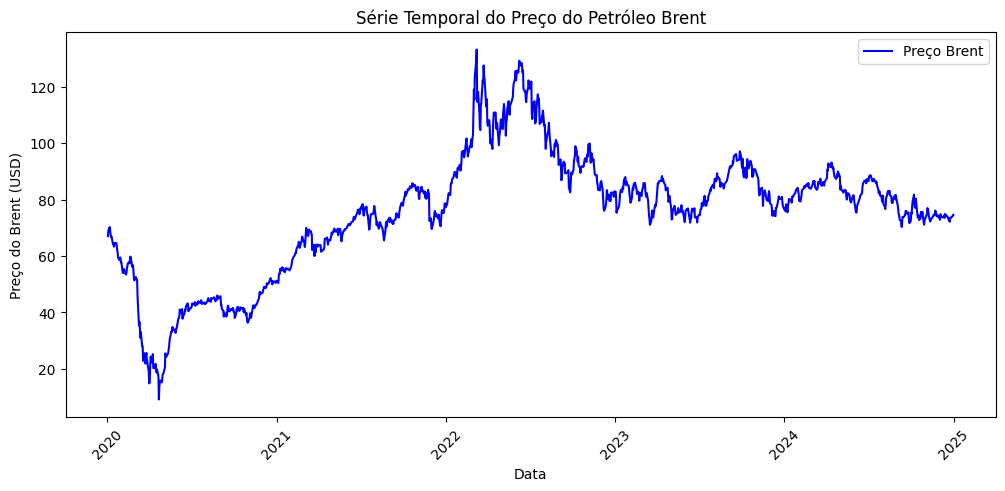

In [44]:
plt.figure(figsize=(12, 5))
plt.plot(df_tratado["DAT_MEDICAO"], df_tratado["VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT"], label="Preço Brent", color='b')
plt.xlabel("Data")
plt.ylabel("Preço do Brent (USD)")
plt.title("Série Temporal do Preço do Petróleo Brent")
plt.legend()
plt.xticks(rotation=45)
plt.show()

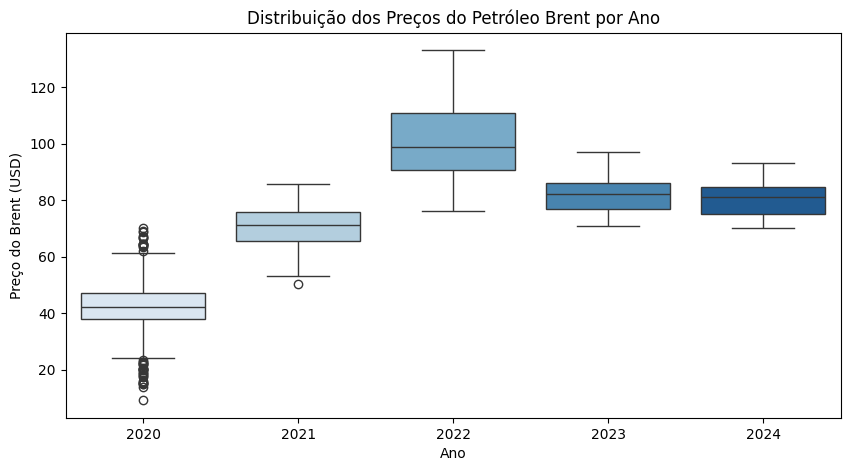

In [45]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_tratado["NUM_ANO"].astype(str),
            y=df_tratado["VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT"],
            hue=df_tratado["NUM_ANO"].astype(str),
            palette="Blues",
            legend=False)

plt.xlabel("Ano")
plt.ylabel("Preço do Brent (USD)")
plt.title("Distribuição dos Preços do Petróleo Brent por Ano")
plt.show()

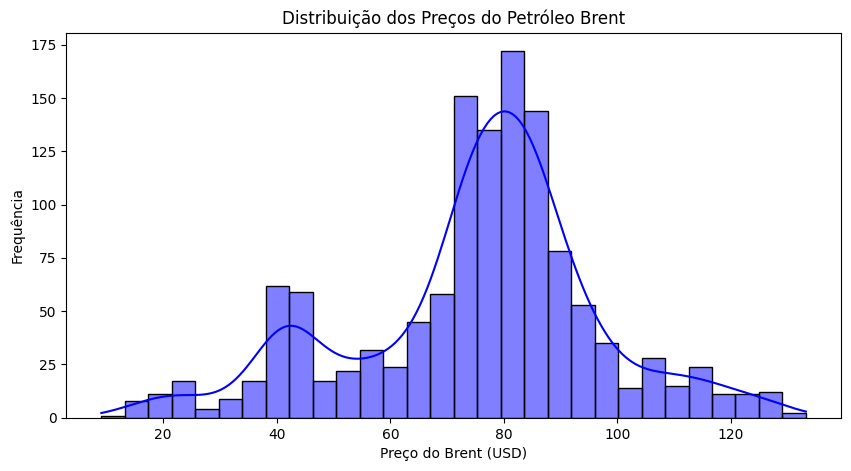

In [46]:
plt.figure(figsize=(10, 5))
sns.histplot(df_tratado["VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT"], bins=30, kde=True, color='b')
plt.xlabel("Preço do Brent (USD)")
plt.ylabel("Frequência")
plt.title("Distribuição dos Preços do Petróleo Brent")
plt.show()

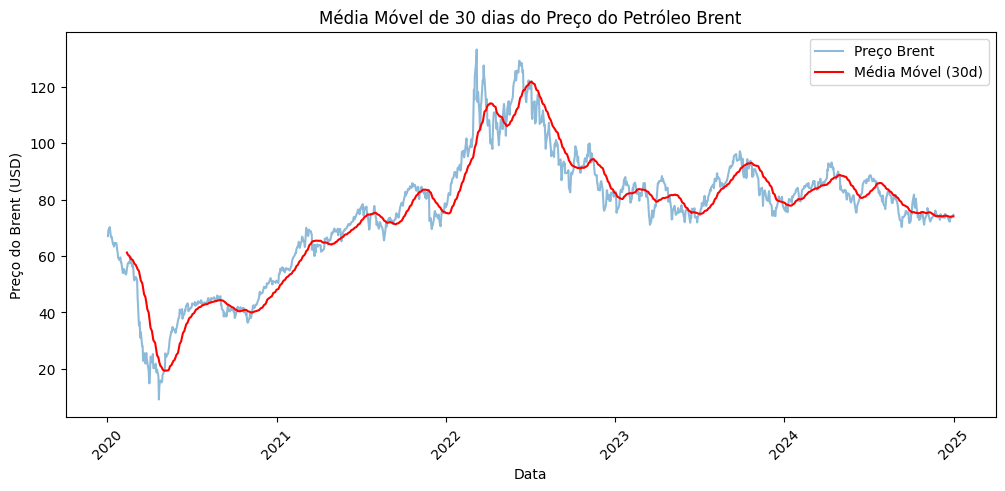

In [47]:
df_tratado["Media_Movel_30d"] = df_tratado["VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT"].rolling(window=30).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_tratado["DAT_MEDICAO"], df_tratado["VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT"], label="Preço Brent", alpha=0.5)
plt.plot(df_tratado["DAT_MEDICAO"], df_tratado["Media_Movel_30d"], label="Média Móvel (30d)", color='r')
plt.xlabel("Data")
plt.ylabel("Preço do Brent (USD)")
plt.title("Média Móvel de 30 dias do Preço do Petróleo Brent")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 9. Modelo SARIMAX

### 9.1. Teste de estacionariedade (Dickey-Fuller)

In [48]:
def testar_estacionariedade(serie):
    resultado = adfuller(serie, autolag='AIC')
    print(f"Estatística de Teste: {resultado[0]}")
    print(f"Valor-p: {resultado[1]}")
    print("Valores Críticos:")
    for chave, valor in resultado[4].items():
        print(f"   {chave}: {valor}")
    if resultado[1] <= 0.05:
        print("\nA série é estacionária.")
    else:
        print("\nA série NÃO é estacionária. Aplicando diferenciação...")

testar_estacionariedade(df_tratado['VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT'])

Estatística de Teste: -1.4456817574094845
Valor-p: 0.5601905394434206
Valores Críticos:
   1%: -3.4355340425478706
   5%: -2.863829299639741
   10%: -2.5679888467643406

A série NÃO é estacionária. Aplicando diferenciação...


In [49]:
df_tratado['d1'] = df_tratado['VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT'].diff().dropna()

testar_estacionariedade(df_tratado['d1'].dropna())

Estatística de Teste: -16.5445394702388
Valor-p: 1.9700824788587625e-29
Valores Críticos:
   1%: -3.4355340425478706
   5%: -2.863829299639741
   10%: -2.5679888467643406

A série é estacionária.


### 9.2. Gráficos de autocorrelação

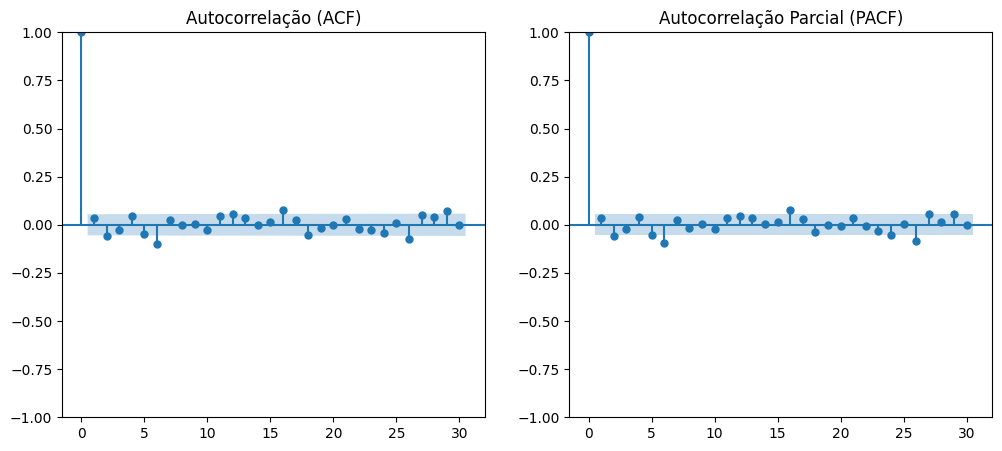

In [50]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_acf(df_tratado['d1'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelação (ACF)')

plt.subplot(122)
plot_pacf(df_tratado['d1'].dropna(), lags=30, ax=plt.gca())
plt.title('Autocorrelação Parcial (PACF)')

plt.show()

### 9.3. Definicão dos parâmetros

In [51]:
modelo_sarima = SARIMAX(df_tratado['VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 12))
ajuste_sarima = modelo_sarima.fit()

print(ajuste_sarima.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20622D+00    |proj g|=  1.50611D-01


 This problem is unconstrained.



At iterate    5    f=  2.11499D+00    |proj g|=  2.57682D-02

At iterate   10    f=  2.11091D+00    |proj g|=  2.20774D-03

At iterate   15    f=  2.11059D+00    |proj g|=  5.80840D-04

At iterate   20    f=  2.11040D+00    |proj g|=  4.46864D-03

At iterate   25    f=  2.11032D+00    |proj g|=  3.27392D-04

At iterate   30    f=  2.11018D+00    |proj g|=  2.00799D-03

At iterate   35    f=  2.11002D+00    |proj g|=  6.67917D-04

At iterate   40    f=  2.11001D+00    |proj g|=  1.36677D-03

At iterate   45    f=  2.10991D+00    |proj g|=  9.39689D-04


/Users/baprado/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.10983D+00    |proj g|=  2.40560D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   2.406D-03   2.110D+00
  F =   2.1098319151225495     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                         SARIMAX Results                                         
Dep. Variable:     VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT   No. Observations:                 1271
Model:                    SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -2681.596
Date:                                   Mon, 17 Feb 2025   AIC     

### 9.4. Previsões

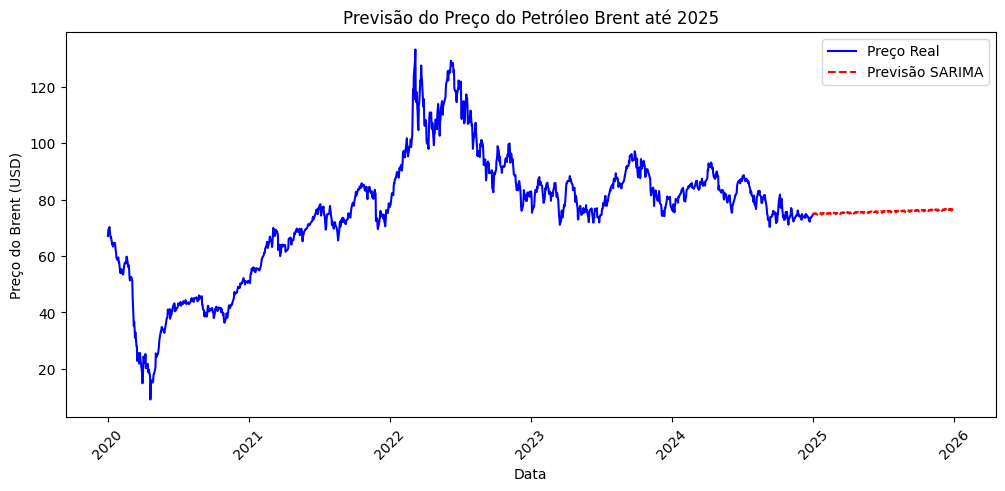

In [52]:
dias_prever = (pd.Timestamp("2025-12-31") - df_tratado["DAT_MEDICAO"].max()).days

previsoes_sarima = ajuste_sarima.forecast(steps=dias_prever)

datas_futuras = pd.date_range(start=df_tratado["DAT_MEDICAO"].max(), periods=dias_prever, freq='D')

df_previsao = pd.DataFrame({"DAT_MEDICAO": datas_futuras, "PREVISAO_BRENT": previsoes_sarima})

plt.figure(figsize=(12, 5))
plt.plot(df_tratado["DAT_MEDICAO"], df_tratado["VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT"], label="Preço Real", color='blue')
plt.plot(df_previsao["DAT_MEDICAO"], df_previsao["PREVISAO_BRENT"], linestyle='dashed', color='red', label="Previsão SARIMA")
plt.xlabel("Data")
plt.ylabel("Preço do Brent (USD)")
plt.title("Previsão do Preço do Petróleo Brent até 2025")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 10. Modelo PROPHET

19:45:31 - cmdstanpy - INFO - Chain [1] start processing
19:45:31 - cmdstanpy - INFO - Chain [1] done processing


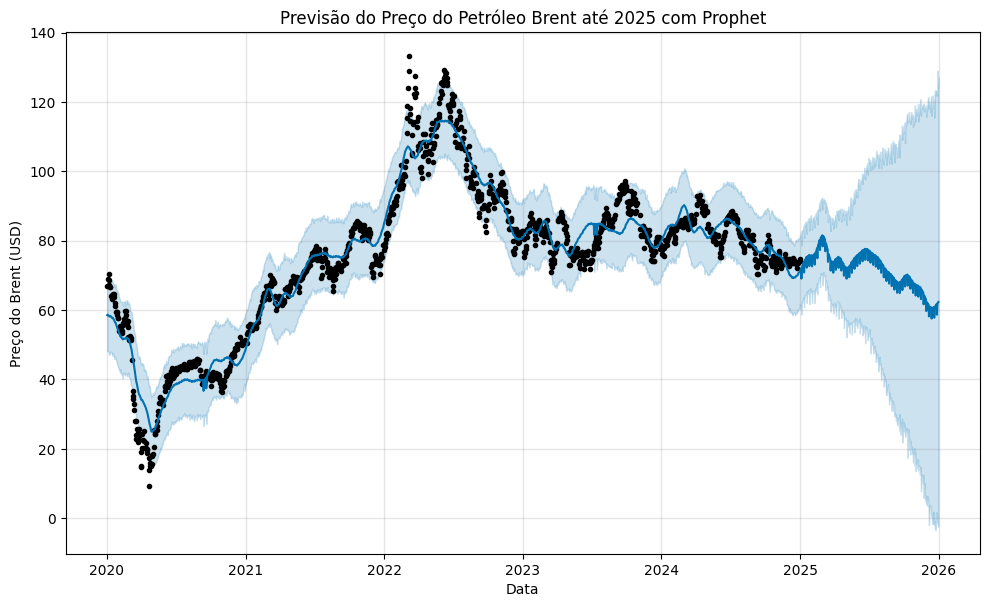

In [53]:
df_prophet = df_tratado[['DAT_MEDICAO', 'VLR_PRECO_PRETROLEO_BRUTO_DOLAR_BRENT']]
df_prophet.columns = ['ds', 'y']

modelo_prophet = Prophet(interval_width=0.95)
modelo_prophet.fit(df_prophet)

future = modelo_prophet.make_future_dataframe(periods=(pd.Timestamp("2025-12-31") - df_prophet['ds'].max()).days, freq='D')
forecast = modelo_prophet.predict(future)

fig = modelo_prophet.plot(forecast)
plt.xlabel("Data")
plt.ylabel("Preço do Brent (USD)")
plt.title("Previsão do Preço do Petróleo Brent até 2025 com Prophet")
plt.show()

### 10.1. Salvar o arquivo no diretório atual

In [ ]:
with open('modelo_prophet.pkl', 'wb') as f:
    pickle.dump(modelo_prophet, f)

In [58]:
pip install PyGithub

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 409 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 349 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.6 MB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 14.9 MB/s eta 0:00:01
     |████████████████████████████████| 117 kB 15.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### 10.2. Subir arquivo atualizado para o repositório no GitHub

In [ ]:
from github import Github
import base64

token = '' # dado sensível não inserido

repo_nome = 'Baaprado/Pos_Tech_FIAP_Fase_4'

arquivo_local = 'modelo_prophet.pkl'

arquivo_repo = 'modelo_prophet.pkl'

commit_message = 'Atualização do modelo Prophet'

g = Github(token)
repo = g.get_repo(repo_nome)

with open(arquivo_local, 'rb') as f:
    conteudo = f.read()

conteudo_base64 = base64.b64encode(conteudo).decode('utf-8')

try:
    conteudo_existente = repo.get_contents(arquivo_repo)
    repo.update_file(arquivo_repo, commit_message, conteudo_base64, conteudo_existente.sha)
    print("Arquivo atualizado no GitHub.")
except:
    repo.create_file(arquivo_repo, commit_message, conteudo_base64)
    print("Arquivo criado no GitHub.")

Arquivo atualizado no GitHub.


### 10.3. Leitura e teste do modelo via GitHub

In [ ]:
url = 'https://raw.githubusercontent.com/Baaprado/Pos_Tech_FIAP_Fase_4/main/modelo_prophet.pkl'

response = requests.get(url)
response.raise_for_status()  

with io.BytesIO(response.content) as f:
    modelo_prophet = pickle.load(f)

future = modelo_prophet.make_future_dataframe(periods=365)

forecast = modelo_prophet.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds       yhat  yhat_lower  yhat_upper
1631 2025-12-27  58.643330   -4.404963  121.844953
1632 2025-12-28  61.455133   -2.130348  125.165299
1633 2025-12-29  62.049753    1.171348  126.438846
1634 2025-12-30  62.210469    0.320654  123.645702
1635 2025-12-31  62.308750   -0.803300  126.010814
